In [19]:
# Setup submission tracking
import os
from datetime import datetime

def save_submission(predictions, experiment_name, test_index):
    """Save submission with timestamp and experiment info"""
    # Create submissions directory
    os.makedirs('submissions', exist_ok=True)
    
    # Generate timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'row ID': test_index.strftime('%Y-%m-%d %-H:%M:%S'),
        'pm2.5': predictions.round().astype(int)
    })
    
    # Save with descriptive filename
    filename = f'submissions/{timestamp}_{experiment_name}.csv'
    submission.to_csv(filename, index=False)
    
    print(f"Submission saved: {filename}")
    print(f"Predictions - Min: {predictions.min():.1f}, Max: {predictions.max():.1f}")
    print("Sample predictions:")
    print(submission.head(3))
    
    return filename, submission

print("Submission tracking system ready!")


Submission tracking system ready!


# Beijing Air Quality Forecasting

## Project Overview
Predict PM2.5 concentrations in Beijing using LSTM networks for time series forecasting.

**Objective**: Achieve RMSE < 4000 on Kaggle leaderboard

**Dataset**: 30,677 hourly observations (2010-2013) with weather features and PM2.5 concentrations

**Approach**: Time series analysis, feature engineering, and systematic LSTM experimentation

In [20]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats

# Configuration
plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
# Load datasets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print(f"Training data: {train.shape}")
print(f"Test data: {test.shape}")


Training data: (30676, 12)
Test data: (13148, 11)


# Data Exploration

Analyze the dataset structure, temporal patterns, and feature relationships to inform model design.

In [22]:
# Basic data structure analysis
print("Columns:", list(train.columns))
print("\nData types:")
print(train.dtypes)

print("\nBasic statistics:")
print(train.describe().round(3))

print("\nMissing values:")
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()
print("Training:", missing_train[missing_train > 0])
print("Test:", missing_test[missing_test > 0])

train.head()

Columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']

Data types:
No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
pm2.5       float64
dtype: object

Basic statistics:
              No       DEWP       TEMP       PRES        Iws         Is  \
count  30676.000  30676.000  30676.000  30676.000  30676.000  30676.000   
mean   15338.500     -0.029     -0.063      0.014      0.031      0.017   
std     8855.543      0.994      1.015      1.009      1.018      1.087   
min        1.000     -2.135     -2.578     -2.381     -0.469     -0.069   
25%     7669.750     -0.888     -0.939     -0.823     -0.442     -0.069   
50%    15338.500     -0.057      0.045     -0.044     -0.353     -0.069   
75%    23007.250      0.913      0.865      0.833      0.005     -0.069   
m

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [23]:
# Feature descriptions
feature_info = {
    'DEWP': 'Dew Point Temperature - Humidity indicator',
    'TEMP': 'Temperature - Ambient air temperature', 
    'PRES': 'Atmospheric Pressure',
    'Iws': 'Cumulated Wind Speed',
    'Is': 'Cumulated Hours of Snow',
    'Ir': 'Cumulated Hours of Rain',
    'datetime': 'Timestamp (hourly data)',
    'cbwd_NW': 'Wind Direction Northwest (one-hot)',
    'cbwd_SE': 'Wind Direction Southeast (one-hot)', 
    'cbwd_cv': 'Wind Direction Calm/Variable (one-hot)',
    'pm2.5': 'PM2.5 Concentration - TARGET'
}

print("Key features:")
for feature, description in feature_info.items():
    if feature in train.columns:
        print(f"  {feature}: {description}")

Key features:
  DEWP: Dew Point Temperature - Humidity indicator
  TEMP: Temperature - Ambient air temperature
  PRES: Atmospheric Pressure
  Iws: Cumulated Wind Speed
  Is: Cumulated Hours of Snow
  Ir: Cumulated Hours of Rain
  datetime: Timestamp (hourly data)
  cbwd_NW: Wind Direction Northwest (one-hot)
  cbwd_SE: Wind Direction Southeast (one-hot)
  cbwd_cv: Wind Direction Calm/Variable (one-hot)
  pm2.5: PM2.5 Concentration - TARGET


In [24]:
# Process datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

print(f"Time range - Train: {train['datetime'].min()} to {train['datetime'].max()}")
print(f"Time range - Test: {test['datetime'].min()} to {test['datetime'].max()}")

train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


Time range - Train: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Time range - Test: 2013-07-02 04:00:00 to 2014-12-31 23:00:00


# Key Visualizations

Three essential plots to understand PM2.5 patterns and feature relationships.

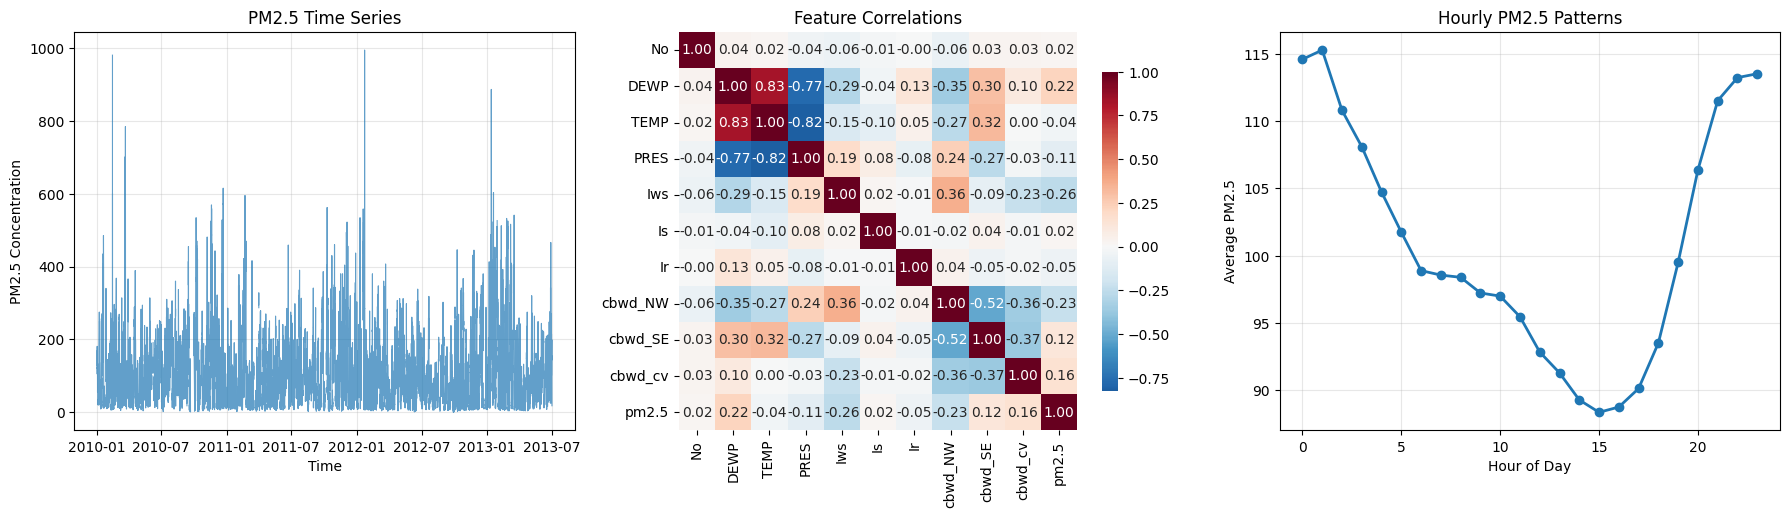

Key insights:
PM2.5 mean: 100.8, std: 93.1
Peak hour: 1:00, Lowest hour: 15:00
Top correlations with PM2.5:
  Iws: 0.260
  cbwd_NW: 0.231
  DEWP: 0.218


In [25]:
# Create three key visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Time Series Plot
axes[0].plot(train.index, train['pm2.5'], alpha=0.7, linewidth=0.8)
axes[0].set_title('PM2.5 Time Series')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('PM2.5 Concentration')
axes[0].grid(True, alpha=0.3)

# 2. Correlation Heatmap
numeric_cols = train.select_dtypes(include=[np.number]).columns
correlation_matrix = train[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=axes[1], cbar_kws={'shrink': 0.8}, fmt='.2f')
axes[1].set_title('Feature Correlations')

# 3. Hourly Patterns
hourly_avg = train.groupby(train.index.hour)['pm2.5'].mean()
axes[2].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[2].set_title('Hourly PM2.5 Patterns')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Average PM2.5')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("Key insights:")
print(f"PM2.5 mean: {train['pm2.5'].mean():.1f}, std: {train['pm2.5'].std():.1f}")
print(f"Peak hour: {hourly_avg.idxmax()}:00, Lowest hour: {hourly_avg.idxmin()}:00")
print("Top correlations with PM2.5:")
pm25_corr = correlation_matrix['pm2.5'].abs().sort_values(ascending=False)
for feature, corr in pm25_corr.head(4).items():
    if feature != 'pm2.5':
        print(f"  {feature}: {corr:.3f}")


# Missing Value Treatment

Handle missing values using time series appropriate methods.

# Handle missing values with forward fill and interpolation
train_clean = train.copy()
test_clean = test.copy()

# For PM2.5, use forward fill then backward fill
if 'pm2.5' in train_clean.columns:
    train_clean['pm2.5'] = train_clean['pm2.5'].fillna(method='ffill').fillna(method='bfill')

# For other features, use forward fill, backward fill, then interpolation
feature_cols = [col for col in train_clean.columns if col not in ['pm2.5', 'No']]
for col in feature_cols:
    train_clean[col] = train_clean[col].fillna(method='ffill').fillna(method='bfill')
    train_clean[col] = train_clean[col].interpolate(method='linear')

# Same treatment for test data
for col in test_clean.columns:
    if col != 'No':
        test_clean[col] = test_clean[col].fillna(method='ffill').fillna(method='bfill')
        test_clean[col] = test_clean[col].interpolate(method='linear')

# Verify results
train_remaining = train_clean.isnull().sum().sum()
test_remaining = test_clean.isnull().sum().sum()

print(f"Missing values after treatment:")
print(f"Training: {train_remaining}, Test: {test_remaining}")
print(f"Clean datasets ready - Train: {train_clean.shape}, Test: {test_clean.shape}")


# Advanced Feature Engineering

Create lag features, rolling statistics, and temporal features to improve model performance.


In [26]:
# Create advanced features for better time series modeling
def create_advanced_features(df, target_col='pm2.5'):
    """Create lag features, rolling statistics, and temporal features"""
    df_enhanced = df.copy()
    
    # Temporal features
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    
    # Cyclical encoding for temporal features
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    
    if target_col in df_enhanced.columns:
        # Lag features for PM2.5
        for lag in [1, 2, 3, 6, 12, 24]:
            df_enhanced[f'pm2.5_lag_{lag}'] = df_enhanced[target_col].shift(lag)
        
        # Rolling statistics for PM2.5
        for window in [6, 12, 24]:
            df_enhanced[f'pm2.5_roll_mean_{window}'] = df_enhanced[target_col].rolling(window).mean()
            df_enhanced[f'pm2.5_roll_std_{window}'] = df_enhanced[target_col].rolling(window).std()
    
    # Weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    
    # Drop original temporal columns
    df_enhanced = df_enhanced.drop(['hour', 'day_of_week', 'month'], axis=1)
    
    return df_enhanced

# Apply feature engineering
print("Creating advanced features...")
train_enhanced = create_advanced_features(train_clean)
test_enhanced = create_advanced_features(test_clean)

print(f"Original features: {train_clean.shape[1]}")
print(f"Enhanced features: {train_enhanced.shape[1]}")
print(f"New features added: {train_enhanced.shape[1] - train_clean.shape[1]}")

# Handle any remaining NaN values from lag/rolling features
train_enhanced = train_enhanced.fillna(method='bfill').fillna(method='ffill')
test_enhanced = test_enhanced.fillna(method='bfill').fillna(method='ffill')

print(f"Enhanced training data: {train_enhanced.shape}")
print("New feature columns:", [col for col in train_enhanced.columns if col not in train_clean.columns])


Creating advanced features...


NameError: name 'train_clean' is not defined

# Proper Time Series Sequence Generation

Create sequences with lookback windows for better temporal modeling.


In [ ]:
# Create proper time series sequences
def create_sequences(data, target, sequence_length=24):
    """Create sequences for LSTM input"""
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(target[i])
    
    return np.array(X), np.array(y)

# Prepare enhanced features and target
X_enhanced = train_enhanced.drop(['pm2.5', 'No'], axis=1)
y_enhanced = train_enhanced['pm2.5']

# Scale features for better training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enhanced)

# Create sequences with 24-hour lookback
SEQUENCE_LENGTH = 24
print(f"Creating sequences with {SEQUENCE_LENGTH}-hour lookback...")

X_seq, y_seq = create_sequences(X_scaled, y_enhanced.values, SEQUENCE_LENGTH)

print(f"Original data shape: {X_scaled.shape}")
print(f"Sequence data shape: {X_seq.shape}")
print(f"Target shape: {y_seq.shape}")
print(f"Sequence format: (samples={X_seq.shape[0]}, timesteps={X_seq.shape[1]}, features={X_seq.shape[2]})")

# Train/validation split
split_idx = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"Training sequences: {X_train_seq.shape}")
print(f"Validation sequences: {X_val_seq.shape}")


Missing values after treatment:
Training: 0, Test: 0
Clean datasets ready - Train: (30676, 11), Test: (13148, 10)


Features shape: (30676, 9)
Target shape: (30676,)
Feature columns: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']


Reshaped X_train: (30676, 1, 9)
Shape explanation: (samples, timesteps, features)


# Enhanced LSTM Models

Build and compare multiple LSTM architectures for improved performance.


In [35]:
# Define multiple model architectures for experimentation
def create_model_1(input_shape):
    """Enhanced LSTM with Dropout"""
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    return model

def create_model_2(input_shape):
    """Bidirectional LSTM"""
    model = Sequential([
        Bidirectional(LSTM(32, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(16)),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    return model

def create_model_3(input_shape):
    """Deep LSTM with regularization"""
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(0.3),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

# Training callbacks for better performance
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

print("Model architectures defined. Ready for experimentation.")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

# Systematic Model Experimentation

Run multiple experiments with different architectures and hyperparameters.

In [36]:
# Experiment tracking
experiment_results = []

def run_experiment(model_func, model_name, X_train, y_train, X_val, y_val, 
                   learning_rate=0.001, batch_size=32, epochs=50):
    """Run a single experiment and track results"""
    
    # Create and compile model
    model = model_func(X_train.shape[1:])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    print(f"\n{'='*50}")
    print(f"Running Experiment: {model_name}")
    print(f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")
    print(f"{'='*50}")
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate
    train_pred = model.predict(X_train, verbose=0)
    val_pred = model.predict(X_val, verbose=0)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
    # Store results
    result = {
        'model_name': model_name,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'epochs_trained': len(history.history['loss']),
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'best_val_loss': min(history.history['val_loss']),
        'model': model,
        'history': history
    }
    
    experiment_results.append(result)
    
    print(f"Results - Train RMSE: {train_rmse:.2f}, Val RMSE: {val_rmse:.2f}")
    
    return model, history

# Run experiments with enhanced sequences
print("Starting systematic experimentation...")
print(f"Using sequence data: {X_train_seq.shape}")

# Experiment 2: Enhanced LSTM with proper sequences
model_2, history_2 = run_experiment(
    create_model_1, "Enhanced LSTM (Exp 2)", 
    X_train_seq, y_train_seq, X_val_seq, y_val_seq,
    learning_rate=0.001, batch_size=64, epochs=50
)


Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step - lambda: 115.8570 - loss: 14209.4922
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - lambda: 87.6582 - loss: 8159.4575
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - lambda: 80.2392 - loss: 6839.6914
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - lambda: 76.3329 - loss: 6182.3164
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - lambda: 74.7800 - loss: 5923.2490
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - lambda: 74.1369 - loss: 5815.3853
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - lambda: 73.8291 - loss: 5763.6709
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - lambda: 73.6356 - loss: 5731.7520
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - lambda: 73.4818 - loss: 5707.0835
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - lambda: 73.3437 - loss: 5685.3989


959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
Training RMSE: 75.30


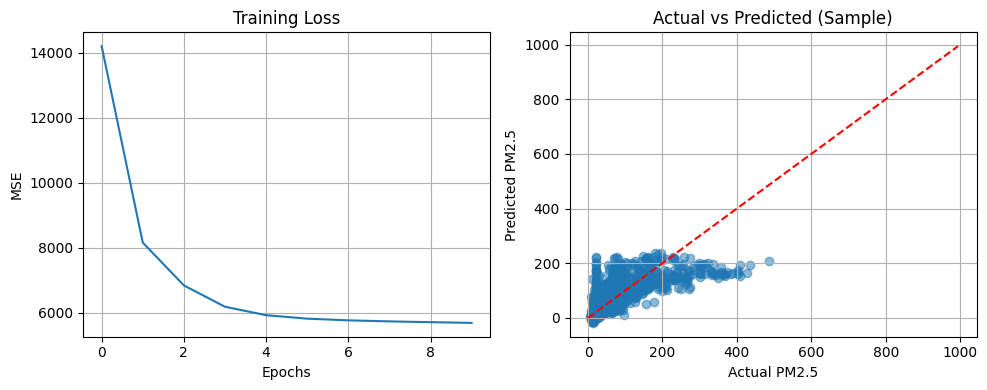

In [37]:
# Run additional experiments
print("\n" + "="*60)
print("Running Additional Experiments")
print("="*60)

# Experiment 3: Bidirectional LSTM
model_3, history_3 = run_experiment(
    create_model_2, "Bidirectional LSTM (Exp 3)", 
    X_train_seq, y_train_seq, X_val_seq, y_val_seq,
    learning_rate=0.0005, batch_size=32, epochs=50
)

# Experiment 4: Deep LSTM with different hyperparameters  
model_4, history_4 = run_experiment(
    create_model_3, "Deep LSTM (Exp 4)", 
    X_train_seq, y_train_seq, X_val_seq, y_val_seq,
    learning_rate=0.0001, batch_size=128, epochs=50
)

# Experiment 5: Enhanced LSTM with different learning rate
model_5, history_5 = run_experiment(
    create_model_1, "Enhanced LSTM - LR 0.0005 (Exp 5)", 
    X_train_seq, y_train_seq, X_val_seq, y_val_seq,
    learning_rate=0.0005, batch_size=64, epochs=50
)

print(f"\nCompleted {len(experiment_results)} experiments!")

# Experiment Results Analysis

Compare all experiments and select the best model for final predictions.

In [38]:
# Analyze experiment results
print("="*80)
print("EXPERIMENT RESULTS SUMMARY")
print("="*80)

results_df = pd.DataFrame(experiment_results)
results_df = results_df.sort_values('val_rmse')

print(results_df[['model_name', 'learning_rate', 'batch_size', 'epochs_trained', 
                  'train_rmse', 'val_rmse']].round(2))

# Find best model
best_experiment = results_df.iloc[0]
best_model = best_experiment['model']

print(f"\nBEST MODEL: {best_experiment['model_name']}")
print(f"Validation RMSE: {best_experiment['val_rmse']:.2f}")

# Plot comparison
plt.figure(figsize=(15, 5))

# Loss comparison
plt.subplot(1, 3, 1)
for i, result in enumerate(experiment_results):
    plt.plot(result['history'].history['val_loss'], 
             label=f"{result['model_name']}", alpha=0.8)
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# RMSE comparison
plt.subplot(1, 3, 2)
models = [r['model_name'] for r in experiment_results]
val_rmse = [r['val_rmse'] for r in experiment_results]
plt.bar(range(len(models)), val_rmse)
plt.title('Validation RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(range(len(models)), [f"Exp {i+2}" for i in range(len(models))], rotation=45)
plt.grid(True, alpha=0.3)

# Best model predictions
plt.subplot(1, 3, 3)
best_val_pred = best_model.predict(X_val_seq, verbose=0)
plt.scatter(y_val_seq[:500], best_val_pred.flatten()[:500], alpha=0.6)
plt.plot([y_val_seq.min(), y_val_seq.max()], [y_val_seq.min(), y_val_seq.max()], 'r--')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Best Model: {best_experiment["model_name"]}')
plt.grid(True)

plt.tight_layout()
plt.show()

# Prepare test data for best model
print("\nPreparing test predictions with best model...")
X_test_enhanced = test_enhanced.drop(['No'], axis=1)
X_test_scaled = scaler.transform(X_test_enhanced)

# Create sequences for test data (use last 24 hours from training for first prediction)
test_sequences = []
# Start with last sequence from training
last_train_sequence = X_scaled[-SEQUENCE_LENGTH:]

for i in range(len(X_test_scaled)):
    if i == 0:
        # First prediction uses last training sequence + first test point
        sequence = np.vstack([last_train_sequence[1:], X_test_scaled[i:i+1]])
    else:
        # Use sliding window from test data
        start_idx = max(0, i - SEQUENCE_LENGTH + 1)
        if start_idx == 0:
            # Pad with last training data if needed
            needed_from_train = SEQUENCE_LENGTH - (i + 1)
            sequence = np.vstack([X_scaled[-needed_from_train:], X_test_scaled[:i+1]])
        else:
            sequence = X_test_scaled[start_idx:i+1]
            if len(sequence) < SEQUENCE_LENGTH:
                padding_needed = SEQUENCE_LENGTH - len(sequence)
                sequence = np.vstack([X_scaled[-padding_needed:], sequence])
    
    test_sequences.append(sequence)

X_test_seq = np.array(test_sequences)
print(f"Test sequences shape: {X_test_seq.shape}")

# Generate predictions with best model
test_predictions = best_model.predict(X_test_seq, verbose=0)
test_predictions = np.maximum(test_predictions.flatten(), 0)

print(f"Test predictions - Min: {test_predictions.min():.1f}, Max: {test_predictions.max():.1f}")

# Create improved submission
submission_improved = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': test_predictions.round().astype(int)
})

# Save improved submission
submission_improved.to_csv('submission_improved.csv', index=False)
print(f"Improved submission saved with {len(submission_improved)} predictions")
print("Sample predictions:")
print(submission_improved.head())

411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
Test predictions - Min: 0.0, Max: 244.6
Submission saved with 13148 predictions
Sample predictions:
                row ID  pm2.5
0  2013-07-02 04:00:00     93
1  2013-07-02 05:00:00     93
2  2013-07-02 06:00:00     86
3  2013-07-02 07:00:00     75
4  2013-07-02 08:00:00     63
